## German Credit Optimization
<p>Optimal Revenue and Risk
<p>Given Operational Requirements

In [521]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
%matplotlib inline

In [522]:
df = pd.read_csv('~/Documents/My Samples/germancredit_out.csv')
n = len(df)
df.describe()

,duration2,amount5,age13,cards16,checkingstatus1_A12,checkingstatus1_A13,checkingstatus1_A14,history3_A31,history3_A32,history3_A33,...,"age_group_(50, 60]","age_group_(60, 90]",installment8_2,installment8_3,installment8_4,residence11_2,residence11_3,residence11_4,liable18_2,risk
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,...,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,20.903000,3271.258000,35.546000,1.407000,0.269000,0.063000,0.394000,0.049000,0.530000,0.088000,...,0.068000,0.045000,0.231000,0.157000,0.476000,0.308000,0.149000,0.413000,0.155000,0.313961
std,12.058814,2822.736876,11.375469,0.577654,0.443662,0.243085,0.488879,0.215976,0.499349,0.283437,...,0.251872,0.207408,0.421683,0.363983,0.499674,0.461898,0.356267,0.492619,0.362086,0.263942
min,4.000000,250.000000,19.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003333
25%,12.000000,1365.500000,27.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.104931
50%,18.000000,2319.500000,33.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.202952
75%,24.000000,3972.250000,42.000000,2.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.488839
max,72.000000,18424.000000,75.000000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.931225


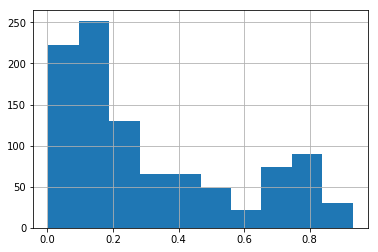

In [523]:
df.risk.hist()

In [524]:
from scipy.optimize import linprog

In [525]:
# Objective Coefficients
# Revenue : c * x 
c = df.amount5/df.amount5.sum()

In [526]:
# Equality Constraints

In [527]:
# Inequality Constraints
# 1) Volume : 1 * x <= 0.85 * n
# 2) Risk   : 1(r > 0.50) * x  <= 0.95 * sum(1(r > 0.50))
# 3) Age 25_: 1(x_age <= 25) * x <= 0.50 * sum(1(x_age <= 25))

A_ub = np.array([
    np.ones(n),
    (df.risk >= .5).values.astype('int'),
    (df.age13 <= 25).values.astype('int')
])

b_ub = np.array([
    int(0.85 * n),
    int(0.95 * np.sum(df.risk >= .5)),
    int(0.50 * np.sum(df.age13 <= 25))
])

In [528]:
res = linprog(-c, A_ub=A_ub, b_ub=b_ub, bounds=(0, 1))
print('Optimal value:', -res.fun)
pd.Series(res.x).value_counts()

Optimal value: 0.953019602856


1.0    850
0.0    150
dtype: int64

In [529]:
np.matmul(A_ub,res.x)

array([ 850.,  198.,   95.])

In [530]:
out = pd.DataFrame()

for ratio in range(10,50,3):
    b_ub = np.array([
        int(0.850 * n),
        int(ratio/100. * np.sum(df.risk >= .5)),
        int(0.80 * np.sum(df.age13 <= 25))
    ])
    res = linprog(-c, A_ub=A_ub, b_ub=b_ub,bounds=(0, 1))
    print('\n\n\nStatus:',res.status, '  / Constraint Slack =',res.slack[:3])
    print(pd.Series(res.x[(res.x>1e-9) & (res.x<1-1e-9)]).value_counts())
    print('\n PCT={:3d} Revenue {:.2%}'.format(ratio,-res.fun))
    out[ratio] = np.array([-res.fun,
                           np.dot(df.risk,res.x)/df.risk.sum()]+list(np.matmul(A_ub,res.x)))




Status: 0   / Constraint Slack = [ 69.   0.  23.]
Series([], dtype: int64)

 PCT= 10 Revenue 78.91%



Status: 0   / Constraint Slack = [ 62.   0.  22.]
Series([], dtype: int64)

 PCT= 13 Revenue 80.83%



Status: 0   / Constraint Slack = [ 55.   0.  21.]
Series([], dtype: int64)

 PCT= 16 Revenue 82.51%



Status: 0   / Constraint Slack = [ 47.   0.  19.]
Series([], dtype: int64)

 PCT= 19 Revenue 84.25%



Status: 0   / Constraint Slack = [ 40.   0.  17.]
Series([], dtype: int64)

 PCT= 22 Revenue 85.67%



Status: 0   / Constraint Slack = [ 33.   0.  15.]
Series([], dtype: int64)

 PCT= 25 Revenue 87.00%



Status: 0   / Constraint Slack = [ 25.   0.  13.]
Series([], dtype: int64)

 PCT= 28 Revenue 88.32%



Status: 0   / Constraint Slack = [ 18.   0.  11.]
Series([], dtype: int64)

 PCT= 31 Revenue 89.34%



Status: 0   / Constraint Slack = [ 11.   0.  10.]
Series([], dtype: int64)

 PCT= 34 Revenue 90.28%



Status: 0   / Constraint Slack = [ 4.  0.  9.]
Series([], dtype: int64

In [531]:
out.index = ['Revenue','Risk','Volume','Risk50+','Age25Count']
out.transpose().style.format('{:.2f}').bar()

,Revenue,Risk,Volume,Risk50+,Age25Count
10,0.79,0.49,781.00,24.00,129.00
13,0.81,0.51,788.00,31.00,130.00
16,0.83,0.53,795.00,38.00,131.00
19,0.84,0.54,803.00,46.00,133.00
22,0.86,0.56,810.00,53.00,135.00
25,0.87,0.58,817.00,60.00,137.00
28,0.88,0.60,825.00,68.00,139.00
31,0.89,0.61,832.00,75.00,141.00
34,0.90,0.63,839.00,82.00,142.00
37,0.91,0.64,846.00,89.00,143.00


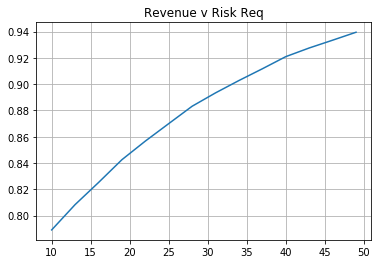

In [535]:
_ = out.transpose().Revenue.plot(title='Revenue v Risk Req',grid=True)

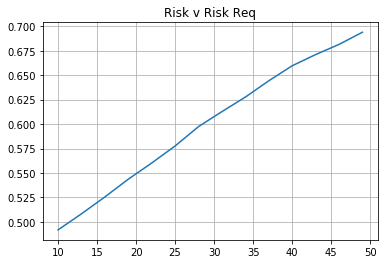

In [536]:
_ = out.transpose().Risk.plot(title='Risk v Risk Req',grid=True)

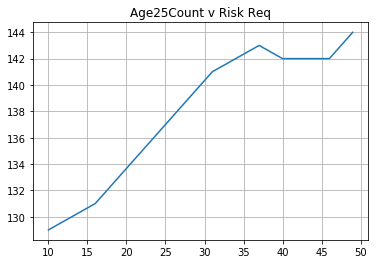

In [537]:
_ = out.transpose().Age25Count.plot(title='Age25Count v Risk Req',grid=True)